# Gender Classification

In [1]:
import os
import pandas as pd
import librosa 
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch.optim.adam
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io.wavfile import write

from IPython.display import Audio



In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CUDA available: True
CUDA version: 12.4
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


In [3]:
IMAGE_PATH = '../doc/images/' # path to save images for LaTeX import
AUDIO_PATH = 'data/cv-corpus-16.1-delta-2023-12-06/en/clips/' # path to audio files
LABEL_PATH = 'data/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv' # path to labels

## Functions

In [4]:
def table_to_latex(df: pd.DataFrame, filename: str) -> None:
    """
    Exports a pandas DataFrame to a LaTeX file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to export.
    - filename (str): The name of the file (without extension) where the LaTeX table will be saved.
    """
    # Generate LaTeX code from the DataFrame
    latex_code = df.to_latex(index=False, escape=True)

    
    with open(f"../doc/tables/{filename}.tex", "w") as f:
        f.write(latex_code)


## Data Analyses

### Load labels

In [5]:
labels = pd.read_csv(LABEL_PATH, sep='\t', header=0,) # load labels from tsv file
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   3408 non-null   object 
 1   path        3408 non-null   object 
 2   sentence    3408 non-null   object 
 3   up_votes    3408 non-null   int64  
 4   down_votes  3408 non-null   int64  
 5   age         3079 non-null   object 
 6   gender      3076 non-null   object 
 7   accents     3188 non-null   object 
 8   variant     0 non-null      float64
 9   locale      3408 non-null   object 
 10  segment     0 non-null      float64
dtypes: float64(2), int64(2), object(7)
memory usage: 293.0+ KB


### Filtering

gender
male      1528
female    1498
other       50
Name: count, dtype: int64


/tmp/ipykernel_6368/1240865572.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels['gender'] = labels['gender'].replace({'male': 0, 'female': 1}).astype(int)


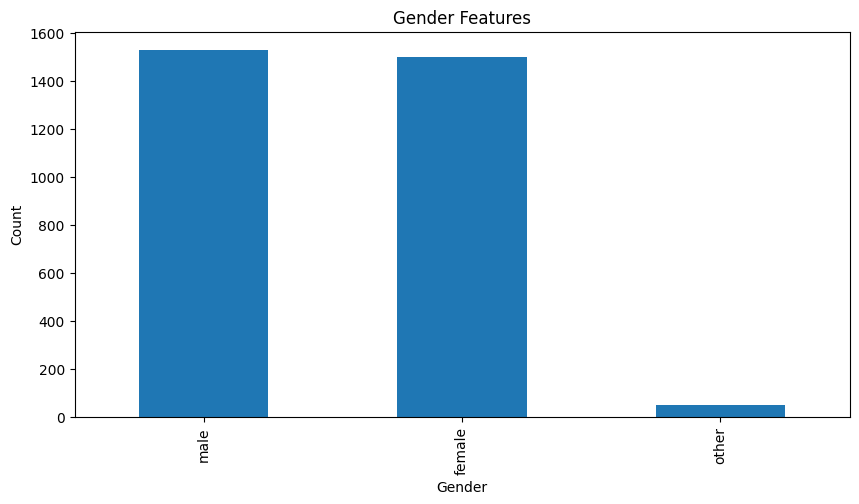

In [6]:
# drop unecesary columns
labels = labels.drop(columns=['client_id',
                              'up_votes', 
                              'down_votes', 
                              'accents', 
                              'locale', 
                              'segment', 
                              'variant', 
                              'sentence',])

# drop rows with missing values
labels = labels.dropna(subset=['gender'])
print(labels['gender'].value_counts())

# Create the bar plot
gender_feature_plot = labels['gender'].value_counts().plot(kind='bar', figsize=(10, 5))
gender_feature_plot.set_title('Gender Features')  # Set title for the plot
gender_feature_plot.set_xlabel('Gender')          # Set x-axis label
gender_feature_plot.set_ylabel('Count')           # Set y-axis label

experiment_labels = labels[labels['gender'].isin(['other'])]

# Filter the DataFrame to keep only rows where 'gender' is 'male' or 'female'
labels = labels[labels['gender'].isin(['male', 'female'])]


# replace the string values with integers
labels['gender'] = labels['gender'].replace({'male': 0, 'female': 1}).astype(int)


### Exports

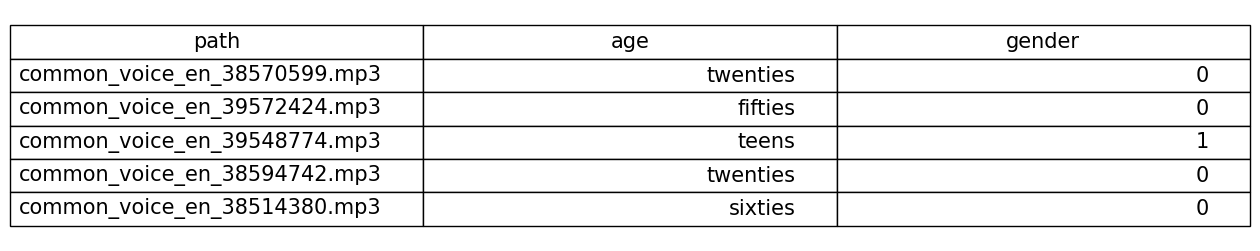

In [7]:
# Save the figure
fig = gender_feature_plot.get_figure()
fig.savefig(IMAGE_PATH + 'gender_features.png', dpi=600, bbox_inches='tight', transparent=True)
table_to_latex(labels.head(), 'features')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 3))  # Adjust figsize for better image quality
ax.axis('tight')
ax.axis('off')

# Render the table
table = ax.table(cellText=labels.head().values, colLabels=labels.head().columns, loc='center')
# Adjust font size
table.auto_set_font_size(False) 
table.set_fontsize(15) 
table.scale(1, 2)  


## Signal Processing

### Audio output

In [8]:
# # Update paths with the base directory path
# paths = [os.path.join(AUDIO_PATH, path) for path in labels['path'].values]

# # Load the audio file (example: first file in paths list)
# audio_data, sample_rate = librosa.load(paths[1], sr=None)  # `sr=None` keeps the original sample rate
# print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")
# Audio(audio_data, rate=sample_rate)

def listen(paths, path_idx=0):
    # Update paths with the base directory path
    paths = [os.path.join(AUDIO_PATH, path) for path in labels['path'].values]

    # Load the audio file (example: first file in paths list)
    audio_data, sample_rate = librosa.load(paths[path_idx], sr=None)  # `sr=None` keeps the original sample rate
    # print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")
    Audio(audio_data, rate=sample_rate)



In [9]:
paths = [os.path.join(AUDIO_PATH, path) for path in labels['path'].values]
for path in paths[:10]:
    audio_data, sample_rate = librosa.load(path, sr=None)
    #audio_data = librosa.effects.trim(audio_data, top_db=30)[0]  # Trim silent edges
    print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}, Time: {len(audio_data)/sample_rate:.2f} seconds")

Number of samples: 124416, sample rate: 32000, Time: 3.89 seconds
Number of samples: 182016, sample rate: 32000, Time: 5.69 seconds
Number of samples: 101376, sample rate: 32000, Time: 3.17 seconds
Number of samples: 140544, sample rate: 32000, Time: 4.39 seconds
Number of samples: 230400, sample rate: 32000, Time: 7.20 seconds
Number of samples: 289152, sample rate: 32000, Time: 9.04 seconds
Number of samples: 139392, sample rate: 32000, Time: 4.36 seconds
Number of samples: 192384, sample rate: 32000, Time: 6.01 seconds
Number of samples: 184320, sample rate: 32000, Time: 5.76 seconds
Number of samples: 171648, sample rate: 32000, Time: 5.36 seconds


### Waveform

171648


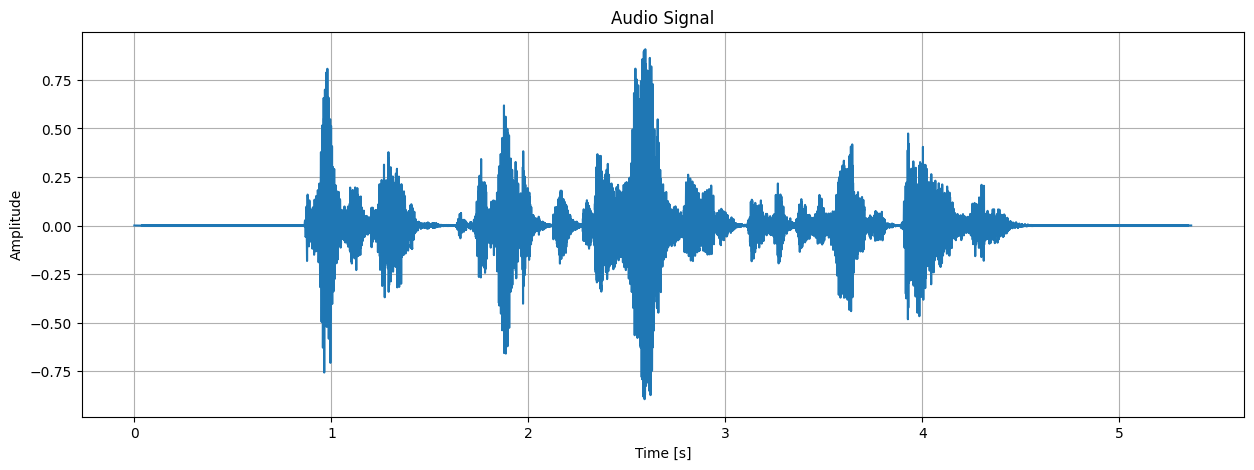

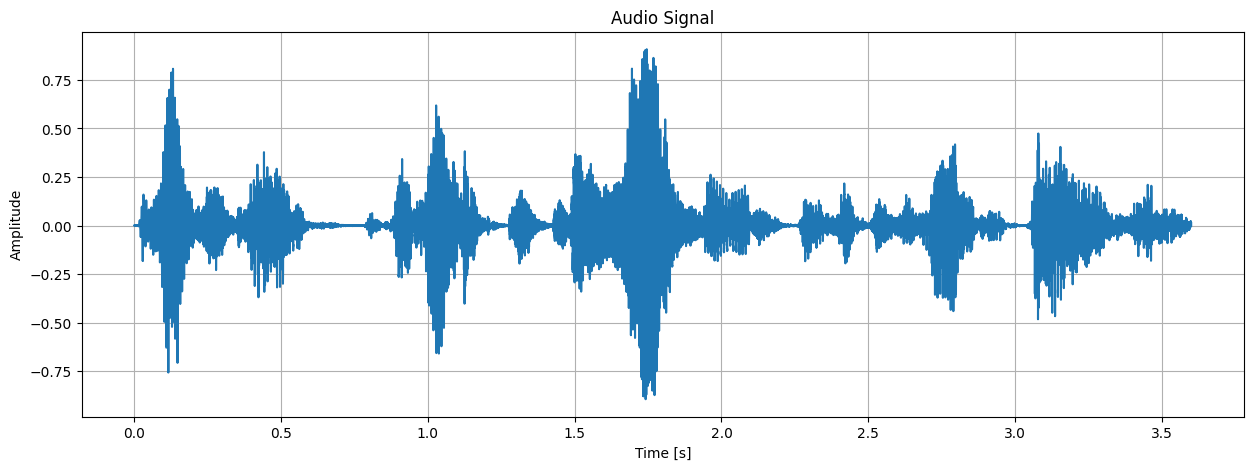

In [10]:
print(len(audio_data))
t = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.figure(figsize=(15, 5))
plt.plot(t, audio_data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.grid()
plt.show()


    # Trim leading and trailing silence from an audio signal
trimmed_audio = librosa.effects.trim(audio_data, top_db=30)[0]

t = np.linspace(0, len(trimmed_audio)/sample_rate, len(trimmed_audio))

plt.figure(figsize=(15, 5))
plt.plot(t, trimmed_audio)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.grid()
plt.show()


### Spectrogram

In [11]:
N = 1024  # FFT window size
hop_length = 256  # Overlap between frames, adjust as needed
window = 'hann'  # Window type

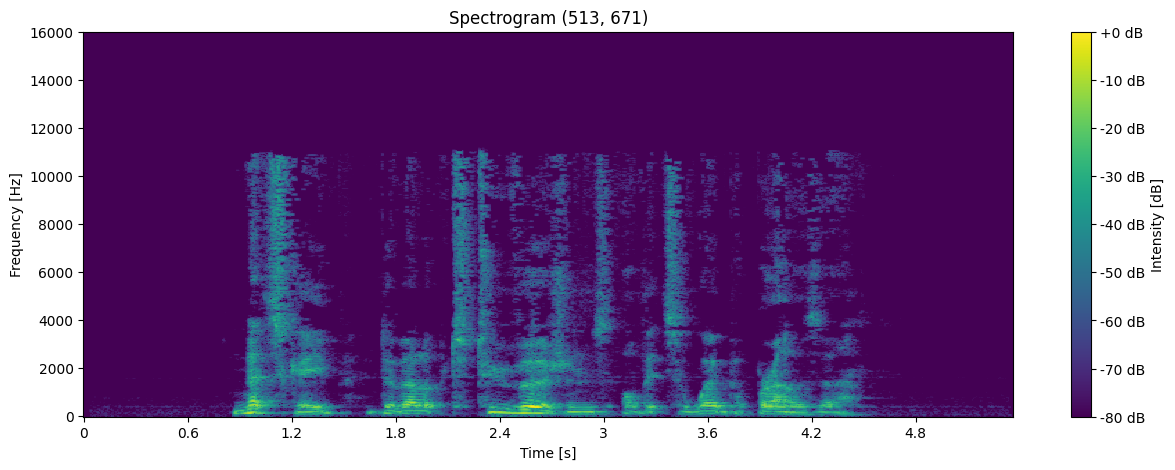

In [12]:
Sx = librosa.stft(audio_data, n_fft=N, hop_length=hop_length, window=window)    # Calculate STFT
Sx_dB = librosa.amplitude_to_db(abs(Sx), ref=np.max)    # spectrogram to dB scale

# Plot the spectrogram
title = f'Spectrogram {Sx_dB.shape}'
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(IMAGE_PATH + title + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [13]:
time_frames = (audio_data.shape[0])/hop_length + 1
time_frames
frequncy_bins = N//2 + 1
time_frames, frequncy_bins

(671.5, 513)

### Melspectrogram

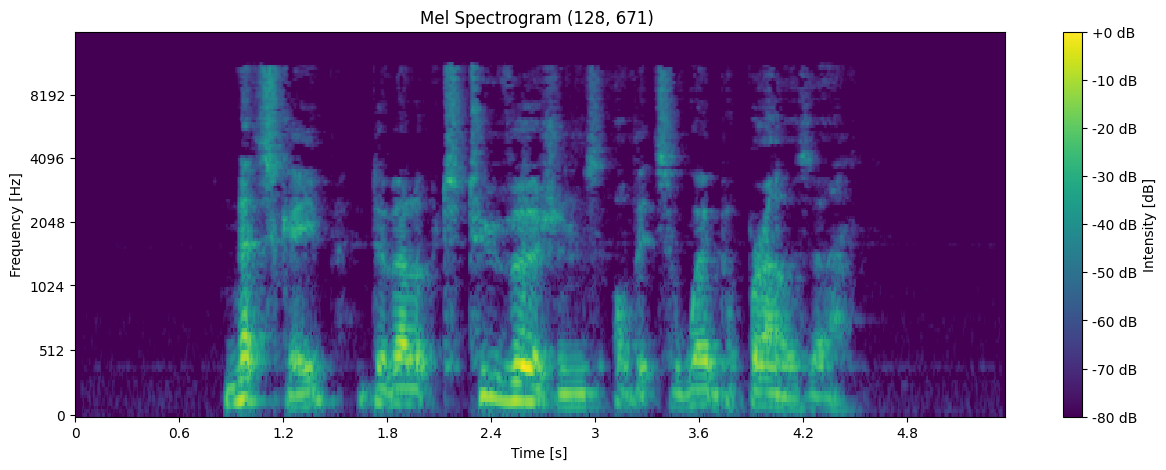

In [14]:
Sx_mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=N, hop_length=hop_length)
Sx_mel_dB = librosa.power_to_db(Sx_mel, ref=np.max)

# Plot the mel spectrogram
title = f'Mel Spectrogram {Sx_mel_dB.shape} '
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_mel_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(IMAGE_PATH + title + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


In [15]:
def extract_mel_spectrogram(audio, sr=22050, n_fft=1024, hop_length=512, n_mels=64, target_shape=(64, 64)):
    
    # Trim leading and trailing silence from an audio signal
    audio = librosa.effects.trim(audio, top_db=30)[0]
    
    # Convert to Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mels=n_mels
    )
    

    # Convert to decibel scale (log scale)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Convert to a PyTorch tensor and add batch and channel dimensions for resizing
    mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Resize the spectrogram to the target shape (64, 44)
    mel_spectrogram = F.interpolate(mel_spectrogram, size=target_shape, mode="bilinear", align_corners=False)
    
    return mel_spectrogram  # Final shape should be [64, 44]


## Deep Learning

### Dataset

In [16]:
class AudioDataset(Dataset):
    def __init__(self, audio_labels, audio_dir, transform=None, target_transform=None):
        self.labels = audio_labels
        self.dir = audio_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.dir, self.labels.iloc[idx, 0])
        audio, _ = librosa.load(audio_path, sr=None)
        spec = extract_mel_spectrogram(audio)

        label = self.labels.iloc[idx, 2]


        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # print(label)
        return spec, label

In [17]:
data = AudioDataset(labels, AUDIO_PATH)

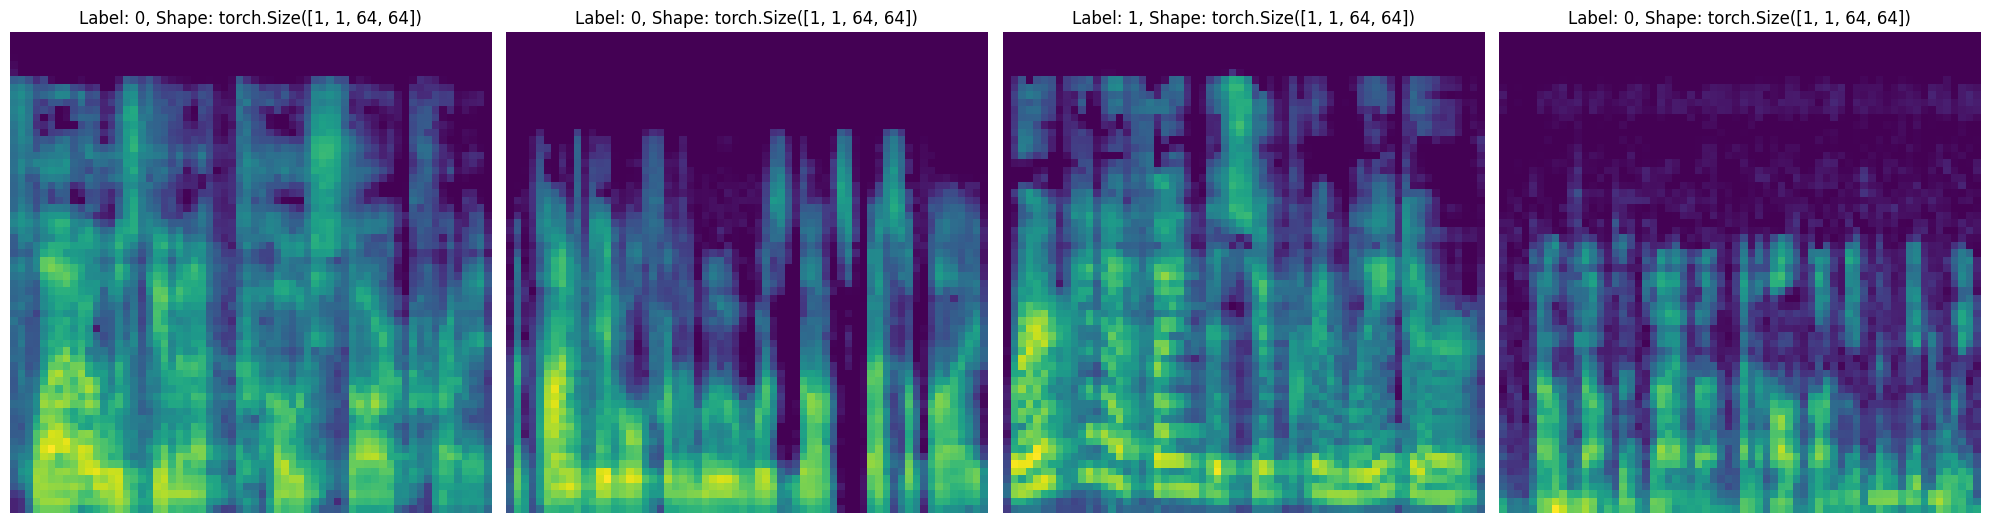

In [18]:
# plot 4 random samples from the dataset
fig, axs = plt.subplots(1,4, figsize=(20, 10))
for i in range(4):
    spec, label = data[i]
    ax = axs[i]
    ax.imshow(spec.squeeze(0).squeeze(0), cmap='viridis', origin='lower')
    ax.set_title(f'Label: {label}, Shape: {spec.shape}')
    ax.axis('off')
plt.tight_layout()

### Create Model

In [19]:
class GenderClassifier2D(nn.Module):
    def __init__(self):
        super(GenderClassifier2D, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=120, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(7680, 128)  # Adjusted based on conv output size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Output layer with 2 units for binary classification
    
    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, features]
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here because CrossEntropyLoss will handle it
        
        return x


In [20]:
# input_size = 64*44 # Flattened spectrogram size
# num_classes = 2         # Binary classification for gender
model = GenderClassifier2D().to(device)
print(model)

GenderClassifier2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(48, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7680, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


### Training and Validation Split

In [21]:
train_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.2])
len(data), len(train_dataset), len(test_dataset)

(3026, 2421, 605)

### Loss function

In [22]:
loss_fn = nn.CrossEntropyLoss()

### Optimizer

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
writer = SummaryWriter("Adam")
writer.add_graph(model, torch.rand(1, 1, 64, 64).to(device))

### Training

In [25]:
def train_one_epoch(epoch_index, writer):
    running_loss = 0.0  # Accumulate loss for averaging

    for i, data in enumerate(train_dataset):
        inputs, labels = data

        # Ensure inputs and labels are tensors with correct shapes
        if not isinstance(inputs, torch.Tensor):
            inputs = torch.tensor(inputs, dtype=torch.float32)
        if inputs.ndim == 2:  # Expected shape is [64, 44]
            inputs = inputs.unsqueeze(0).unsqueeze(0)  # Shape becomes [1, 1, 64, 44]
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels, dtype=torch.long)
        if labels.ndim == 0:
            labels = labels.unsqueeze(0)

        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients for each batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Log per-batch loss
        # writer.add_scalar("Loss/Train (per batch)", loss.item(), epoch_index * len(train_dataset) + i)
        running_loss += loss.item()

        # Print and log average loss every 1000 batches
        if i % 500 == 499:
            avg_loss_1000 = running_loss / 500
            print(f'  batch {i + 1} loss: {avg_loss_1000:.4f}')
            writer.add_scalar('Loss (batch)/Train', avg_loss_1000, epoch_index * len(train_dataset) + i)
            running_loss = 0.0  # Reset running loss for next 1000 batches

    # Return average loss for the epoch
    avg_epoch_loss = running_loss / len(train_dataset)
    return avg_epoch_loss


In [26]:
# Initialize metrics for binary classification
accuracy = torchmetrics.Accuracy(task="binary").to(device)
precision = torchmetrics.Precision(task="binary").to(device)
recall = torchmetrics.Recall(task="binary").to(device)
f1_score = torchmetrics.F1Score(task="binary").to(device)

In [27]:
EPOCHS = 5
epoch_number = 0
best_vloss = float('inf')

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}:')

    # Train for one epoch
    avg_train_loss = train_one_epoch(epoch, writer)

    # Validation loop
    running_val_loss = 0.0
    model.eval()  # Set model to evaluation mode

    # Reset metrics
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()

    with torch.no_grad():
        for i, vdata in enumerate(test_dataset):
            vinputs, vlabels = vdata

            if not isinstance(vinputs, torch.Tensor):
                vinputs = torch.tensor(vinputs, dtype=torch.float32)
            if vinputs.ndim == 2:
                vinputs = vinputs.unsqueeze(0).unsqueeze(0)  # Shape becomes [1, 1, 64, 44]
            if not isinstance(vlabels, torch.Tensor):
                vlabels = torch.tensor(vlabels, dtype=torch.long)
            vlabels = vlabels.view(1)

            # Move to device
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            # Forward pass
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_val_loss += vloss.item()

            # Calculate predictions
            _, preds = torch.max(voutputs, 1)

            # Update metrics
            accuracy.update(preds, vlabels)
            f1_score.update(preds, vlabels)
            precision.update(preds, vlabels)
            recall.update(preds, vlabels)

    avg_val_loss = running_val_loss / len(test_dataset)

    # Compute metrics
    val_accuracy = accuracy.compute().item()
    val_f1 = f1_score.compute().item()
    val_precision = precision.compute().item()
    val_recall = recall.compute().item()

    # Log epoch-level losses and metrics to TensorBoard
    writer.add_scalars('Loss (epoch)/epoch', {
        'train': avg_train_loss,
        'validation': avg_val_loss
    }, epoch)

    writer.add_scalars('Metrics/Validation', {
        'Accuracy': val_accuracy,
        'F1 Score': val_f1,
        'Precision': val_precision,
        'Recall': val_recall
    }, epoch)

    print(f'Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'  Validation Accuracy: {val_accuracy:.4f}')
    print(f'  Validation Precision: {val_precision:.4f}')
    print(f'  Validation Recall: {val_recall:.4f}')
    print(f'  Validation F1 Score: {val_f1:.4f}')

    # Save model if validation loss improves
    if avg_val_loss < best_vloss:
        best_vloss = avg_val_loss
        torch.save(model.state_dict(), f"model_best_epoch_{epoch + 1}.pth")
        print(f'  Model saved as model_best_epoch_{epoch + 1}.pth')


EPOCH 1:
  batch 500 loss: 0.5825
  batch 1000 loss: 0.2359
  batch 1500 loss: 0.2311
  batch 2000 loss: 0.1742
Epoch 1 - Train Loss: 0.0271, Validation Loss: 0.1428
  Validation Accuracy: 0.9570
  Validation Precision: 0.9965
  Validation Recall: 0.9186
  Validation F1 Score: 0.9559
  Model saved as model_best_epoch_1.pth
EPOCH 2:
  batch 500 loss: 0.1519
  batch 1000 loss: 0.0884
  batch 1500 loss: 0.1570
  batch 2000 loss: 0.1082
Epoch 2 - Train Loss: 0.0182, Validation Loss: 0.1057
  Validation Accuracy: 0.9620
  Validation Precision: 0.9797
  Validation Recall: 0.9446
  Validation F1 Score: 0.9619
  Model saved as model_best_epoch_2.pth
EPOCH 3:
  batch 500 loss: 0.1072
  batch 1000 loss: 0.0684
  batch 1500 loss: 0.1268
  batch 2000 loss: 0.0888
Epoch 3 - Train Loss: 0.0133, Validation Loss: 0.1077
  Validation Accuracy: 0.9653
  Validation Precision: 0.9864
  Validation Recall: 0.9446
  Validation F1 Score: 0.9651
EPOCH 4:
  batch 500 loss: 0.0736
  batch 1000 loss: 0.0548
  bat

### Prediction

In [39]:
# experiment_labels
paths = [os.path.join(AUDIO_PATH, path) for path in experiment_labels['path'].values]


# Load the audio file (example: first file in paths list)

audio_data, sample_rate = librosa.load(paths[1], sr=None)  # `sr=None` keeps the original sample rate
# print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")
Audio(audio_data, rate=sample_rate)
len(paths)


50

In [63]:
def predict_gender(audio_data, model):
    model.eval()

    # Preprocess the input
    processed_input = extract_mel_spectrogram(audio_data).to(device)
    # processed_input = processed_input.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    # print(processed_input.shape)
    # Make prediction
    with torch.no_grad():
        output = model(processed_input)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
    
    return predicted_class, probabilities


In [75]:
audio = librosa.load(paths[5], sr=None)[0]


classifier = predict_gender(audio, model)
if classifier[0] == 0:
    print('male')
else:
    print('female')
Audio(audio, rate=sample_rate)

male


In [95]:
voice_path = 'data/pete.wav'
voice_path = 'data/tobi.wav'
voice_path = 'data/chalisa.wav'
# voice_path = 'data/chalisa2.wav'

audio, sample_rate = librosa.load(voice_path, sr=None)
print(f"Number of samples: {len(audio)}, sample rate: {sample_rate}")


# downsample to 32kHz
audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=32000)
sample_rate = 32000


classifier = predict_gender(audio, model)
if classifier[0] == 0:
    print('Male with probability:', classifier[1][0][0].item())
else:
    print('Female with probability:', classifier[1][0][1].item())
print()
Audio(audio, rate=sample_rate)

Number of samples: 190728, sample rate: 48000
Male with probability: 0.5042431354522705



In [44]:
def record_audio(filename='recording.wav', duration=5, sample_rate=48000, device_index=2, channels=2):
    """
    Record audio and save to a .wav file.
    
    Parameters:
    - filename: Name of the output file.
    - duration: Duration of the recording in seconds.
    - sample_rate: Sample rate in Hz.
    - device_index: Index of the capture device.
    - channels: Number of audio channels (1 for mono, 2 for stereo).
    """
    print("Recording...")
    # Record audio with the specified number of channels
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, device=device_index, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording complete.")

    # Save as a .wav file
    write(filename, sample_rate, audio_data)
    print(f"Audio saved as {filename}")


In [32]:
# Load the saved model

In [46]:
record_audio('test.wav', duration=2, device_index=1)

Recording...
Recording complete.
Audio saved as test.wav


In [34]:
# import pyaudio
# import wave

# def record_audio_pyaudio(filename='recording.wav', duration=5, sample_rate=48000, device_index=0):
#     chunk = 1024  # Number of frames per buffer
#     format = pyaudio.paInt16  # 16-bit audio format
#     channels = 1  # Mono
#     rate = sample_rate  # Sample rate

#     p = pyaudio.PyAudio()
#     stream = p.open(format=format,
#                     channels=channels,
#                     rate=rate,
#                     input=True,
#                     frames_per_buffer=chunk,
#                     input_device_index=device_index)  # Set the correct device index

#     print("Recording...")
#     frames = []

#     for _ in range(0, int(rate / chunk * duration)):
#         data = stream.read(chunk)
#         frames.append(data)

#     print("Recording complete.")
#     stream.stop_stream()
#     stream.close()
#     p.terminate()

#     wf = wave.open(filename, 'wb')
#     wf.setnchannels(channels)
#     wf.setsampwidth(p.get_sample_size(format))
#     wf.setframerate(rate)
#     wf.writeframes(b''.join(frames))
#     wf.close()
#     print(f"Audio saved as {filename}")

# # Usage example
# record_audio_pyaudio(duration=5, device_index=0)  # Replace `device_index` with the correct index


Number of samples: 96000, sample rate: 48000


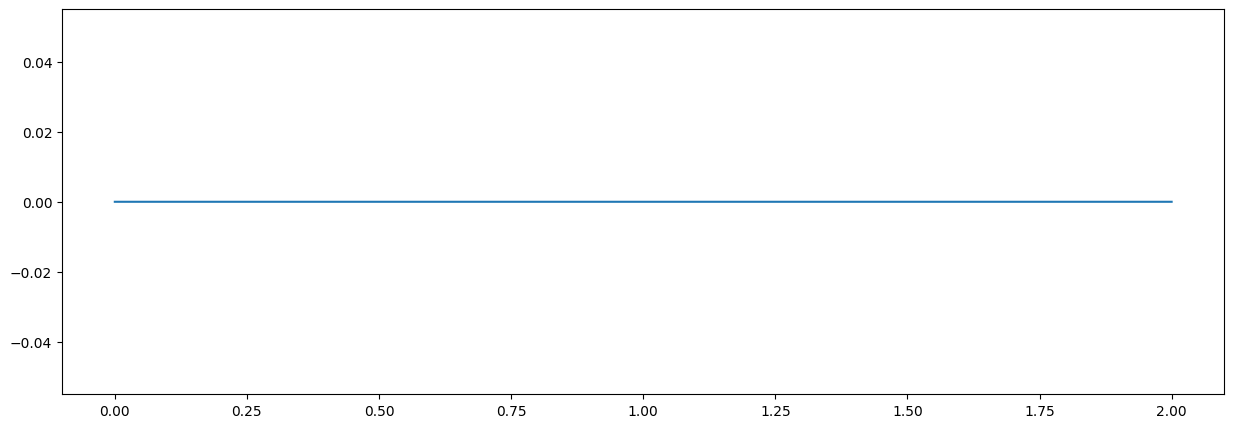

In [47]:
# import soundfile as sf
audio_data, sample_rate = librosa.load('test.wav', sr=None)
print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")

# plot the audio signal
t = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.figure(figsize=(15, 5))
plt.plot(t, audio_data)

